In [9]:
# INFO on all Darwin-time steps I have

AUcm = 1.49598e13 # cm
Msol = 1.989e33 # g
Rsol = 6.955e10 # cm
Lsol = 3.828e26 # W

steplist = [
    '230561',
    '230671',
    '230721',
    '230791',
    '230871',
    '231001',
    '231121',
    '231191',
    '231251',
    '231321',
    '231521'
]

lums = [
 4.011105E+37,
 3.747075E+37,
 3.125607E+37,
 2.327253E+37,
 1.710008E+37,
 1.535925E+37,
 1.719432E+37,
 2.307498E+37,
 3.113407E+37,
 3.719663E+37,
 4.011341E+37
]

rads = [
 3.028534E+13,
 2.952860E+13,
 2.766583E+13,
 2.507058E+13,
 2.286302E+13,
 2.220077E+13,
 2.289833E+13,
 2.500295E+13,
 2.762800E+13,
 2.944892E+13,
 3.028601E+13
]

for time,lum,rad in zip(steplist,lums,rads):
    print(f'model.{time}')
    print(f'Lum: { lum /(Lsol*10000000)} Lsol')
    print(f'Rad: { rad /AUcm} AU')
    print('')

"""
model.230561
Lum: 10478.330721003134 Lsol
Rad: 2.0244481878099974 AU

model.230671
Lum: 9788.597178683385 Lsol
Rad: 1.9738632869423387 AU

model.230721
Lum: 8165.1175548589335 Lsol
Rad: 1.8493449110282223 AU


    NEAREST LUMINOSITY
    model.230791
    Lum: 6079.55329153605 Lsol
    Rad: 1.6758633136806642 AU


model.230871
Lum: 4467.10553814002 Lsol
Rad: 1.5282971697482586 AU

model.231001
Lum: 4012.3432601880872 Lsol
Rad: 1.484028529793179 AU

model.231121
Lum: 4491.724137931034 Lsol
Rad: 1.5306574954210619 AU


    NEAREST RADIUS
    model.231191
    Lum: 6027.94670846395 Lsol
    Rad: 1.6713425313172636 AU


model.231251
Lum: 8133.247126436781 Lsol
Rad: 1.8468161339055336 AU

model.231321
Lum: 9716.987983281086 Lsol
Rad: 1.9685370125269055 AU

model.231521
Lum: 10478.947230929989 Lsol
Rad: 2.024492974505007 AU
"""


model.230561
Lum: 10478.330721003134 Lsol
Rad: 2.0244481878099974 AU

model.230671
Lum: 9788.597178683385 Lsol
Rad: 1.9738632869423387 AU

model.230721
Lum: 8165.1175548589335 Lsol
Rad: 1.8493449110282223 AU

model.230791
Lum: 6079.55329153605 Lsol
Rad: 1.6758633136806642 AU

model.230871
Lum: 4467.10553814002 Lsol
Rad: 1.5282971697482586 AU

model.231001
Lum: 4012.3432601880872 Lsol
Rad: 1.484028529793179 AU

model.231121
Lum: 4491.724137931034 Lsol
Rad: 1.5306574954210619 AU

model.231191
Lum: 6027.94670846395 Lsol
Rad: 1.6713425313172636 AU

model.231251
Lum: 8133.247126436781 Lsol
Rad: 1.8468161339055336 AU

model.231321
Lum: 9716.987983281086 Lsol
Rad: 1.9685370125269055 AU

model.231521
Lum: 10478.947230929989 Lsol
Rad: 2.024492974505007 AU



(1, 3)

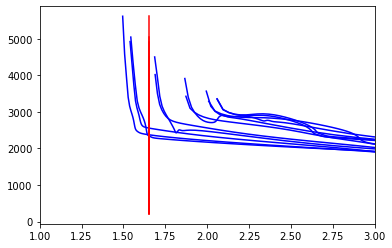

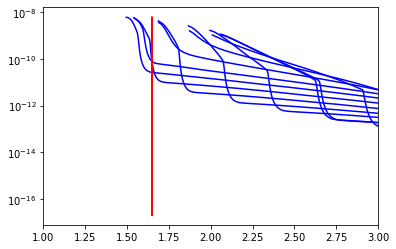

In [23]:
# Read darwin-dat-files
#
# extract 
# Radius, Density, and T_gas - columns
# all are in cgs
#
import matplotlib.pyplot as plt

c5d_star_r_au = 1.651
AUcm = 1.49598e13


modelname = 'M2n315u6'
steplist = [
    '230561',
    '230671',
    '230721',
    '230791',
    '230871',
    '231001',
    '231121',
    '231191',
    '231251',
    '231321',
    '231521'
]



for stepnumber in steplist:

    path = f'../darwin_data/{modelname}_sel/model.{stepnumber}.dat'

    radius_cm = []
    radius_au = []
    gas_density = []
    gas_temperature = []


    with open(path, 'r') as f:
        for nn,line in enumerate(f.readlines()):
            if nn > 18:

                line_list = line.strip().split('  ')

                radius_cm.append(float(line_list[0]))
                radius_au.append(float(line_list[0])/AUcm)
                gas_density.append(float(line_list[1]))
                gas_temperature.append(float(line_list[2]))


    plt.figure(1)
    plt.plot(radius_au,gas_temperature,'b')
    plt.plot(
        [c5d_star_r_au,c5d_star_r_au],
        [min(gas_temperature),max(gas_temperature)],'r'
    )


    plt.figure(2)
    plt.plot(radius_au,gas_density,'b')
    plt.plot(
        [c5d_star_r_au,c5d_star_r_au],
        [min(gas_density),max(gas_density)],'r'
    )
    plt.yscale('log')

plt.figure(1)
plt.xlim(1,3)
plt.figure(2)
plt.xlim(1,3)



Finished 25 per cent of the grid.
Finished 50 per cent of the grid.
Finished 75 per cent of the grid.
DARWIN Dust-star:
    dust_density_darwinstar.inp
    dust_temperature_darwinstar.dat
DONE



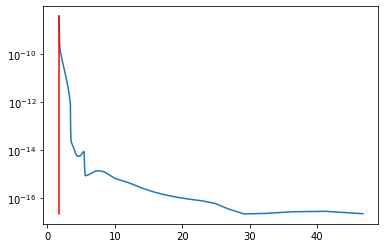

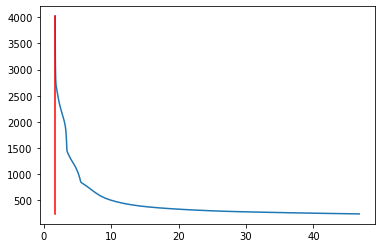

In [1]:
import analyze_darwin_functions as adw

radius,density,temperature = adw.load_darwindata(
    modelname='M2n315u6',
    timestep='230791'
)



import matplotlib.pyplot as plt

c5d_star_r_au = 1.651
AUcm = 1.49598e13


plt.figure(1)
plt.plot(radius/AUcm,density)
plt.plot(
    [c5d_star_r_au,c5d_star_r_au],
    [min(density),max(density)],'r'
)
plt.yscale('log')


plt.figure(2)
plt.plot(radius/AUcm,temperature)
plt.plot(
    [c5d_star_r_au,c5d_star_r_au],
    [min(temperature),max(temperature)],'r'
)

adw.darwin_to_radmc3d(
    darwin_radius=radius,
    darwin_density=density,
    darwin_temperature=temperature,
    gridpath='../r3dresults/st28gm06n052/grid_distances.csv',
    amrpath='../r3dresults/st28gm06n052/amr_grid.inp'
)





Så, hur göra?

1. definiera stjärnan

 * först leta upp vilka data som faktiskt går innanför c5d-stjärnan?
  - eller ska jag försöka normalisera om stjärnan till en sån?
  - samma sak med temperaturen dåju

 * eller ta en medelstjärna av alla data? och sen normalisera om den till en som uppfyller samma storlek o temperatur som co5boldstjärnan?

2. stuva in det i r3d-gridet
 * dvs, sfäriska koordinater, översätta densiteter, temperaturer till data för varje gridcell
 * allt som är inom stjärnan kan ju sättas till konstant densitet o temperatur
 * och så ska radien inte gå utanför co5bold-kuben. Dvs jag inför nog gas-fördelning hela vägen? eller ska jag bara ha gasfördelning upp till en viss radie ovanför stjärnans yta o sen gå över till co5boldgas?
  - med tanke på att med pnktkällorna har jag ingen gas alls, bara stoft så tror jag på det förnämnda mer

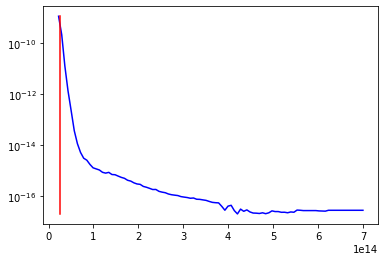

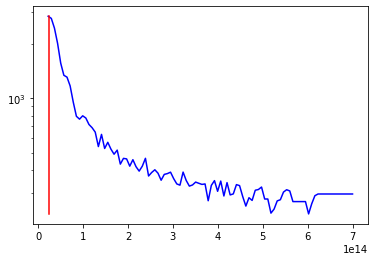

In [1]:
# Test to make an average darwin-star
#
# extract 
# Radius, Density, and T_gas - columns
# all are in cgs
#
import matplotlib.pyplot as plt
import numpy as np
import os
import analyze_r3d_functions as a3d
import create_r3d_functions as c3d

AUcm = 1.49598e13
c5d_star_r_cm = 1.651 * AUcm

modelname = 'M2n315u6'


# Given modelname, list all time-step-files
filenames = os.listdir(f'../darwin_data/{modelname}_sel/')

# Load all Darwin data
Ntimesteps = len(filenames)
Ncells = []
all_radii = []
all_density = []
all_temperature = []

for filename in filenames:

    path = f'../darwin_data/{modelname}_sel/{filename}'

    radius_cm = []
    radius_au = []
    gas_density = []
    gas_temperature = []


    with open(path, 'r') as f:
        for nn,line in enumerate(f.readlines()):
            if nn > 18:

                line_list = line.strip().split('  ')

                radius_cm.append(float(line_list[0]))
                gas_density.append(float(line_list[1]))
                gas_temperature.append(float(line_list[2]))

    # Save and reverse the radial direction
    Ncells.append(len(radius_cm))
    all_radii.append(radius_cm[::-1])
    all_density.append(gas_density[::-1])
    all_temperature.append(gas_temperature[::-1])





# Define grid to average into
Naverage = max(Ncells)
average_radius = np.linspace(
    min(min(all_radii)),
    max(max(all_radii)),
    Naverage
)
average_gas_density = np.zeros(Naverage)
average_gas_T = np.zeros(Naverage)
average_cell_counter = np.zeros(Naverage)


# Loop over each models radius and densities
for nstep in range(Ntimesteps):

    # Loop over all data in each time step
    for nn in range(Ncells[nstep]):

        # Check where these data are closest to average_radius
        for na in range(Naverage - 1):
            if all_radii[nstep][nn] >= average_radius[na] and all_radii[nstep][nn] < average_radius[na+1]:

                average_gas_density[na] += all_density[nstep][nn]
                average_gas_T[na] += all_temperature[nstep][nn]

                average_cell_counter[na] += 1


# Extract all zero-elements as sequence-based lists
hole_lists = c3d.find_zeroelements(average_cell_counter)


# Remove zeros in cell counter
for na in range(Naverage):
    if average_cell_counter[na] == 0:
        average_cell_counter[na] = 1


# Average the data
average_gas_density /= average_cell_counter
average_gas_T /= average_cell_counter



# Average data around holes in average data
for zero_list in hole_lists:

    # Make sure were not in the end of the array
    if zero_list[-1] != Naverage-1:

        # Take average of prev and next index
        average_gas_density[zero_list] = 0.5*(average_gas_density[zero_list[0]-1] + average_gas_density[zero_list[-1]+1])
        average_gas_T[zero_list] = 0.5*(average_gas_T[zero_list[0]-1] + average_gas_T[zero_list[-1]+1])
    
    # For the end of the array, just take the final real value
    if zero_list[-1] == Naverage-1:
        average_gas_density[zero_list] = average_gas_density[zero_list[0]-1] 
        average_gas_T[zero_list] = average_gas_T[zero_list[0]-1]



plt.figure(1)
plt.plot(
    average_radius,
    average_gas_density,
    'b'
)
plt.plot(
    [c5d_star_r_cm,c5d_star_r_cm],
    [average_gas_density.min(),average_gas_density.max()],'r'
)
plt.yscale('log')


plt.figure(2)
plt.plot(
    average_radius,
    average_gas_T,
    'b'
)
plt.plot(
    [c5d_star_r_cm,c5d_star_r_cm],
    [average_gas_T.min(),average_gas_T.max()],'r'
)
plt.yscale('log')


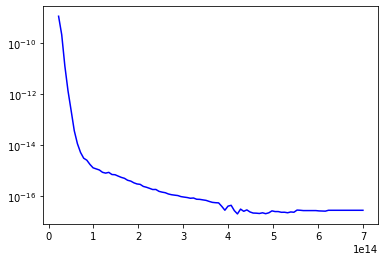

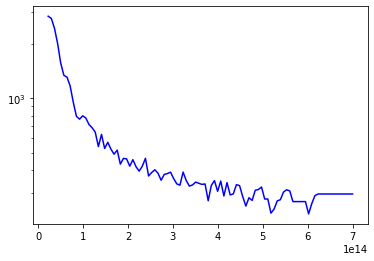

In [2]:
import analyze_darwin_functions as adrw
import matplotlib.pyplot as plt

radius,density,temperature = adrw.load_darwindata(
    modelname='M2n315u6'
)


plt.figure(1)
plt.plot(
    radius,
    density,
    'b'
)
plt.yscale('log')


plt.figure(2)
plt.plot(
    radius,
    temperature,
    'b'
)
plt.yscale('log')

In [87]:
import analyze_r3d_functions as a3d


# Load radial grid of r3d cells (small model!)

r3d_griddistances = a3d.load_griddistances(
    gridpath='../r3dresults/st28gm06n056/grid_distances.csv',
    amrpath='../r3dresults/st28gm06n056/amr_grid.inp',
)
r3d_radius = r3d_griddistances[:,0]

r3d_cellsizes = a3d.load_cellsizes(
    sizepath='../r3dresults/st28gm06n056/grid_cellsizes.csv',
    amrpath='../r3dresults/st28gm06n056/amr_grid.inp'
)


In [3]:
import analyze_r3d_functions as a3d


# Load radial grid of r3d cells (big model!)

r3d_griddistances = a3d.load_griddistances(
    gridpath='../r3dresults/st28gm06n052/grid_distances.csv',
    amrpath='../r3dresults/st28gm06n052/amr_grid.inp',
)
r3d_radius = r3d_griddistances[:,0]

r3d_cellsizes = a3d.load_cellsizes(
    sizepath='../r3dresults/st28gm06n052/grid_cellsizes.csv',
    amrpath='../r3dresults/st28gm06n052/amr_grid.inp'
)

In [4]:
import numpy as np

print(np.shape(r3d_griddistances[:,3]))
print(np.shape(r3d_cellsizes))

(19590712,)
(19590712,)


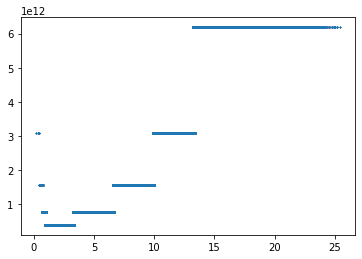

In [5]:
import matplotlib.pyplot as plt
AUcm = 1.49598e13 # AU in cm

plt.plot(r3d_radius/AUcm,r3d_cellsizes,'.',markersize=1)


In [7]:

# do i need to change the order of r3d_radius for this interpolation to work??

# default setting of interp is to keep first o last value outside the range
r3d_darwindensity = np.interp(r3d_radius,average_radius,average_gas_density)
r3d_darwintemperature = np.interp(r3d_radius,average_radius,average_gas_T)


# See plots below
# r3d-datan är ju inte i "radiell led" egentligen, det är bara radiellt fördelade celler nu
# för att det ska vara rätt plottat ska jag ta sfäriska skal och plotta totala datan för alla celler inom dem
# så nästa steg är att göra om siffrorna från sfäriska 1D-koordinater till kartesiska koordinater



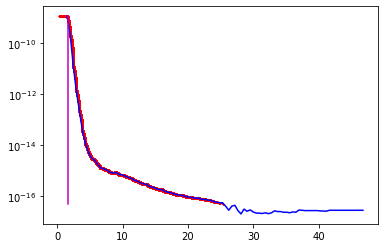

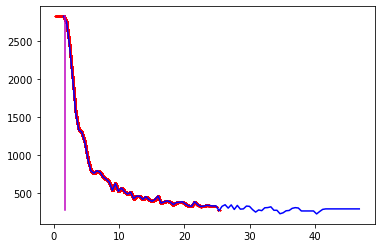

In [8]:
plt.figure(1)
plt.plot(
    r3d_radius/AUcm,
    r3d_darwindensity,
    'r.',markersize=1
)
plt.plot(
    average_radius/AUcm,
    average_gas_density,
    'b'
)
plt.plot(
    [c5d_star_r_cm/AUcm,c5d_star_r_cm/AUcm],
    [r3d_darwindensity.min(),r3d_darwindensity.max()],'m'
)
plt.yscale('log')



plt.figure(2)
plt.plot(
    r3d_radius/AUcm,
    r3d_darwintemperature,
    'r.',markersize=1
)
plt.plot(
    average_radius/AUcm,
    average_gas_T,
    'b'
)
plt.plot(
    [c5d_star_r_cm/AUcm,c5d_star_r_cm/AUcm],
    [r3d_darwintemperature.min(),r3d_darwintemperature.max()],'m'
)



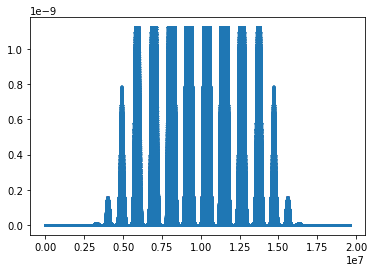

In [100]:
plt.plot(r3d_darwindensity,'.',markersize=1)

In [103]:
np.max(r3d_darwintemperature)

2828.7056384615375

In [11]:
# Write r3d_darwindensity into a dust_density_darwin.inp
# Write r3d_darwintemperature into a dust_temperature_darwin.dat

# nleafs is the same as number of elements in griddistances, cellsizes etc

nleafs = np.size(r3d_radius)
progbar = 0

with open('../dust_density_darwinstar.inp', 'w') as fdensity, \
     open('../dust_temperature_darwinstar.dat', 'w') as ftemperature:
    
    # Write headers:
    # 1
    # nleafs
    # number dust species
    fdensity.write(f'1\n{int(nleafs)}\n1\n')
    ftemperature.write(f'1\n{int(nleafs)}\n1\n')    

    # Write densities and temperatures
    for nr3d in range(nleafs):
        fdensity.write(f'{r3d_darwindensity[nr3d]}\n')
        ftemperature.write(f'{r3d_darwintemperature[nr3d]}\n')

        # Some progress bar info
        if int(nr3d/nleafs*100) == 25 and progbar == 0:
            progbar += 1
            print('Finished 25 per cent of the grid.')

        if int(nr3d/nleafs*100) == 50 and progbar == 1:
            progbar += 1
            print('Finished 50 per cent of the grid.')

        if int(nr3d/nleafs*100) == 75 and progbar == 2:
            progbar += 1
            print('Finished 75 per cent of the grid.')

print(f'DARWIN Dust-star:\n    dust_density_darwinstar.inp\n    dust_temperature_darwinstar.dat\nDONE\n')





Finished 25 per cent of the grid.
Finished 50 per cent of the grid.
Finished 75 per cent of the grid.
DARWIN Dust-star:
    dust_density_darwinstar.inp
    dust_temperature_darwinstar.dat
DONE

